In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

def initialize_environment(N1, N2):
    pi_ref = np.ones((N1, N2)) / N2
    rho = np.ones(N1) / N1
    r = np.random.normal(0, 1, (N1, N2))
    return pi_ref, rho, r


def best_of_n(pi, r, n):
    N1, N2 = pi.shape
    P = (r[:, :, np.newaxis] >= r[:, np.newaxis, :]).astype(float)
    pi_bon = n * pi * np.power(np.einsum('ijk,ik->ij', P, pi), n-1)
    pi_bon /= pi_bon.sum(axis=1, keepdims=True)
    return pi_bon

def update_policy_no_mixing(pi, r, n):
    return best_of_n(pi, r, n)

def update_policy_mixing(pi, pi_ref, r, n, alpha1, alpha2):
    pi_bon = best_of_n(pi, r, n)
    new_pi = np.power(pi_bon, alpha1) * np.power(pi, alpha2) * np.power(pi_ref, 1 - alpha1 - alpha2)
    return new_pi / new_pi.sum(axis=1, keepdims=True)

def wind_update(pi, pi_ref, r, beta, eta):
    N1, N2 = pi.shape
    P = (r[:, :, np.newaxis] >= r[:, np.newaxis, :]).astype(float)
    new_pi = np.zeros_like(pi)
    for i in range(N1):
        numerator = pi[i] ** (1 / (1 + beta * eta)) * pi_ref[i] ** (beta * eta / (1 + beta * eta)) * np.exp(eta / (1 + beta * eta) * np.dot(P[i], pi[i]))
        new_pi[i] = numerator / numerator.sum()
    return new_pi

def run_experiment(N1, N2, n, T, T_nomix, beta, eta):
    pi_ref, rho, r = initialize_environment(N1, N2)

    # No mixing case
    pi_no_mixing = pi_ref.copy()
    pi_star_0 = np.zeros_like(pi_ref)
    for i in range(N1):
        best_actions = np.argwhere(r[i] == r[i].max()).flatten()
        pi_star_0[i, best_actions] = 1 / len(best_actions)

    distances_no_mixing = []
    for t in range(T_nomix):
        pi_no_mixing = update_policy_no_mixing(pi_no_mixing, r, n)
        distances_no_mixing.append(np.mean(np.abs(pi_no_mixing - pi_star_0).sum(axis=1)))

    # Mixing case
    alpha1 = eta / ((1 + beta * eta) * (n - 1))
    alpha2 = (n - 1 - eta) / ((1 + beta * eta) * (n - 1))

    pi_mixing = np.random.dirichlet(np.ones(N2), N1)
    pi_wind = np.random.dirichlet(np.ones(N2), N1)

    distances_mixing = []
    for t in range(T):
        pi_mixing = update_policy_mixing(pi_mixing, pi_ref, r, n, alpha1, alpha2)
        pi_wind = wind_update(pi_wind, pi_ref, r, beta, eta)
        distances_mixing.append(np.mean(np.abs(pi_mixing - pi_wind).sum(axis=1)))

    return distances_no_mixing, distances_mixing

# Run the experiment
N1, N2 = 20, 100
n = 5
T = 200
T_nomix = 20
beta = 0.02
eta = 1

distances_no_mixing, distances_mixing = run_experiment(N1, N2, n, T, T_nomix, beta, eta)



In [ ]:


# plt.figure()
# plt.yscale('log')
# plt.plot(distances_mixing)
# plt.title('Mixing: Distance between Alg. 1 and Alg. 2')
# plt.xlabel('Iteration')
# plt.ylabel('E_x[||π_t,x - π̄^(t)_x||₁]')

# plt.tight_layout()
# plt.show()



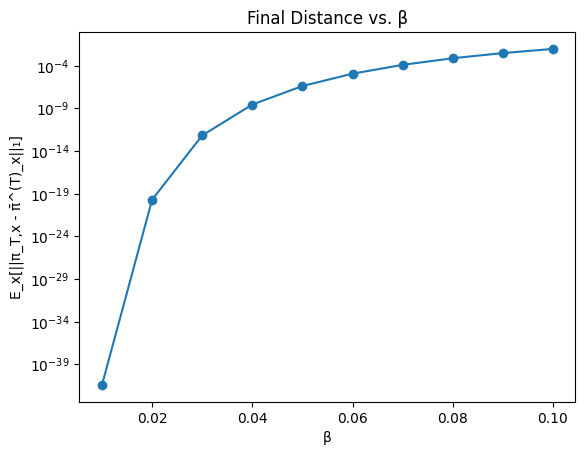

In [ ]:
# Experiment with different beta values
T=5000
np.random.seed(42)
beta_values = np.linspace(0.01, 0.1, 10)
final_distances = []

for beta in beta_values:
    #eta = beta
    _, distances = run_experiment(N1, N2, n, T, T_nomix, beta, eta)
    final_distances.append(distances[-1])

plt.figure()
plt.plot(beta_values, final_distances, '-o')
plt.yscale('log')
plt.title('Final Distance vs. β')
plt.xlabel('β')
plt.ylabel('E_x[||π_T,x - π̄^(T)_x||₁]')
plt.show()

In [ ]:
def run_experiment_with_wind_zero_beta(N1, N2, n, T_1, eta):
    pi_ref, rho, r = initialize_environment(N1, N2)

    # No mixing case
    pi_no_mixing = pi_ref.copy()
    pi_star_0 = np.zeros_like(pi_ref)
    for i in range(N1):
        best_actions = np.argwhere(r[i] == r[i].max()).flatten()
        pi_star_0[i, best_actions] = 1 / len(best_actions)

    distances_no_mixing = []
    for t in range(T_1):
        pi_no_mixing = update_policy_no_mixing(pi_no_mixing, r, n)
        distances_no_mixing.append(np.mean(np.abs(pi_no_mixing - pi_star_0).sum(axis=1)))

    # WIND with β=0
    pi_wind_zero_beta = np.random.dirichlet(np.ones(N2), N1)

    distances_wind_zero_beta = []
    for t in range(T_1):
        pi_wind_zero_beta = wind_update(pi_wind_zero_beta, pi_ref, r, 0, eta)
        distances_wind_zero_beta.append(np.mean(np.abs(pi_wind_zero_beta - pi_star_0).sum(axis=1)))

    return distances_no_mixing, distances_wind_zero_beta



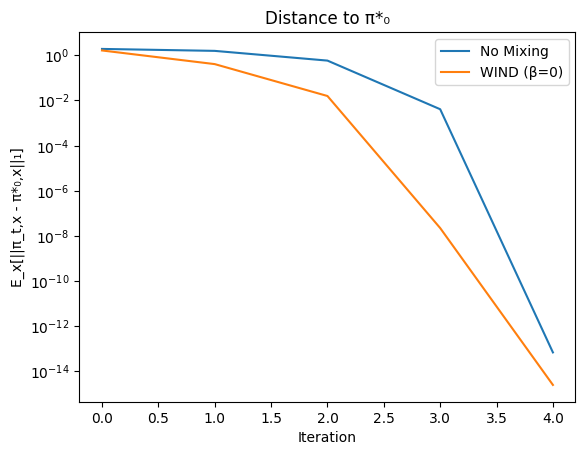

In [ ]:
np.random.seed(42)
eta_zero_beta = 16
distances_no_mixing_zero_beta, distances_wind_zero_beta = run_experiment_with_wind_zero_beta(N1, N2, n, T_1=5, eta = eta_zero_beta)

plt.figure()
plt.yscale('log')
plt.plot(distances_no_mixing_zero_beta, label='No Mixing')
plt.plot(distances_wind_zero_beta, label='WIND (β=0)')
plt.title('Distance to π*₀')
plt.xlabel('Iteration')
plt.ylabel('E_x[||π_t,x - π*₀,x||₁]')
plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/RLHF'

Mounted at /content/drive
/content/drive/My Drive/RLHF


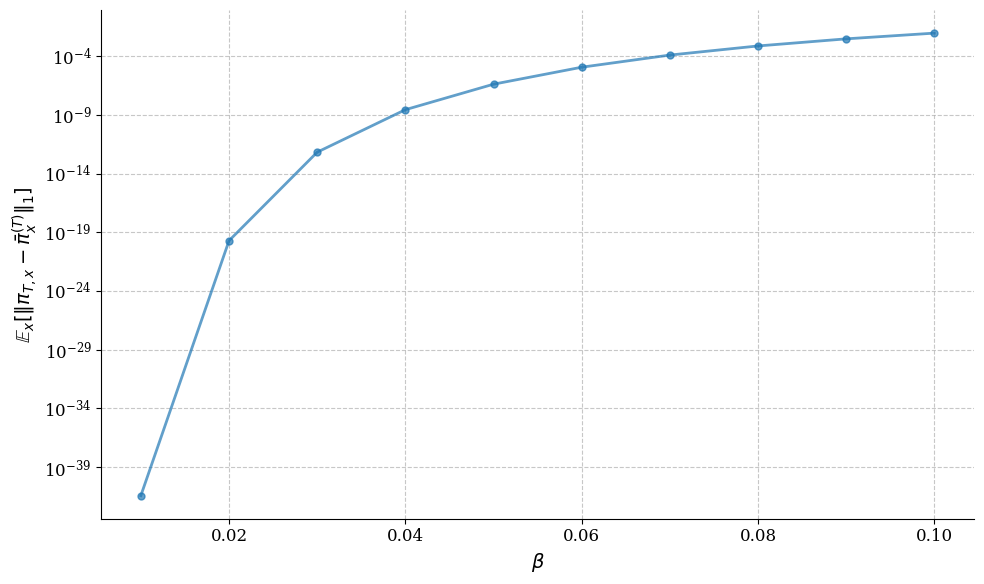

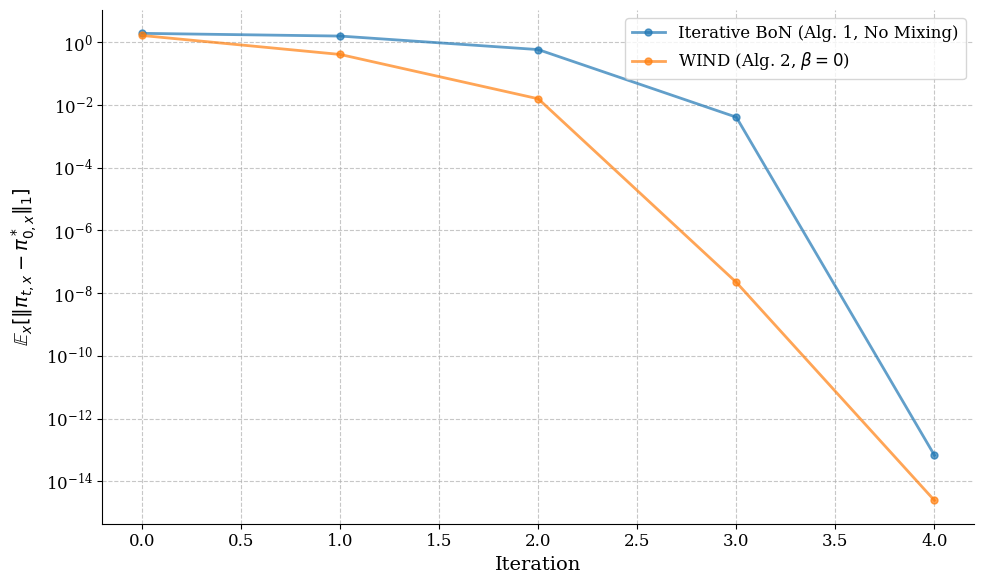

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import to_rgba


# Set up the plot style
# plt.style.use('seaborn-whitegrid')
# rcParams['font.family'] = 'Times New Roman'
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
rcParams['font.size'] = 12
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
rcParams['figure.titlesize'] = 16

def create_pretty_plot(x_data, y_data, xlabel, ylabel, legend_labels, filename, show_legend=True):
    fig, ax = plt.subplots(figsize=(10, 6))

    # colors = ['#4169E1','#FF69B4']  # Royal Blue and Pink
    colors = ['#1f77b4', '#ff7f0e']  # Blue and Orange
    alphas = [0.7, 0.7]  # Semi-transparent

    for i, (x, y, label) in enumerate(zip(x_data, y_data, legend_labels)):
        color = to_rgba(colors[i], alpha=alphas[i])
        ax.plot(x, y, '-o', color=color, label=label if show_legend else "", linewidth=2, markersize=5)

    ax.set_yscale('log')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    if show_legend:
        ax.legend(fontsize=12, frameon=True, fancybox=True, framealpha=0.8, loc='best')

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# # Plot 1: Mixing - Distance between Alg. 1 and Alg. 2 (no legend)
# create_pretty_plot(
#     x_data=[range(len(distances_mixing))],
#     y_data=[distances_mixing],
#     xlabel='Iteration',
#     ylabel=r'$\mathbb{E}_x[\|\pi_{t,x} - \bar{\pi}^{(t)}_x\|_1]$',
#     legend_labels=[''],
#     filename='mixing_distance_plot.pdf',
#     show_legend=False
# )

# Plot 2: Final Distance vs. β (no legend)
create_pretty_plot(
    x_data=[beta_values],
    y_data=[final_distances],
    xlabel=r'$\beta$',
    ylabel=r'$\mathbb{E}_x[\|\pi_{T,x} - \bar{\pi}^{(T)}_x\|_1]$',
    legend_labels=[''],
    filename='mixing.pdf',
    show_legend=False
)

# Plot 3: Distance to π*₀ (with legend)
create_pretty_plot(
    x_data=[range(len(distances_no_mixing_zero_beta)), range(len(distances_wind_zero_beta))],
    y_data=[distances_no_mixing_zero_beta, distances_wind_zero_beta],
    xlabel='Iteration',
    ylabel=r'$\mathbb{E}_x[\|\pi_{t,x} - \pi^*_{0,x}\|_1]$',
    legend_labels=['Iterative BoN (Alg. 1, No Mixing)', r'WIND (Alg. 2, $\beta=0$)'],
    filename='no_mixing.pdf',
    show_legend=True
)